# Coupled Cavity Array Research (UC Davis, Summer 2020)

#### Amelia Broman

In [1]:
import numpy as np
from numpy import linalg as LA

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Functions to generate data

In [2]:
def construct_states_helper(n, m, e_list, arr, state_list, index, tot):
    """Recursively constructs all possible states of a system.
    Parameters: n, the number of cavities.  m, the number of photons.
    e_list, list with elements specifying number of emitters in each cavity.
    arr, a list of length n that we edit to construct a state.
    state_list, a running list of states we've found.
    index, the current index in arr that we're editing.
    tot, the sum of numbers currently placed in arr."""
    
    #base case (state found)
    if tot==m:
        state_list.append(arr.copy()) #make copy so list entry doesn't change when we change arr
        return 
    
    if index in e_inds:
        var_range = 2  #emitters can be 0 or 1
    else:
        var_range = m+1-tot  #photon range narrows as tot approaches m 
    
    #loop over possible values
    for val in range(var_range):  
        arr[index] = val  #place value at index
        new_arr = arr.copy()  #make copy to edit in downwards recursion
        if (index < len(arr)-1 or tot+val==m):  #ensures that we don't go out of index range
            construct_states_helper(n, m, e_list, new_arr, state_list, index+1, tot+val) 
        
    
def construct_states(n, m, e_list):
    """Runs construct_states_helper.
    Parameters:  n, the number of cavities.  m, the number of photons.
    e_list, list with elements specifying number of emitters in each cavity.
    Returns: state_list, an ordered list of basis states."""
    global e_inds, photon_inds
    
    state_list = []
    arr = [0]*(n+sum(e_list))  #array to store state
    
    #find indices of the emitters in arr
    e_inds = []
    count = 0
    for cavity in range(n):  #loop thru cavities
        count+=1  #photon ind
        for i in range(e_list[cavity]):
            e_inds.append(count)  #append emitter index
            count+=1
            
    #all other indices are photon indices
    photon_inds = []
    for i in range(len(arr)):
        if i not in e_inds:
            photon_inds.append(i)
    
    construct_states_helper(n, m, e_list, arr, state_list, index=0, tot=0) 
    
    return state_list
    
def construct_h(n, m, e_list, j_list=None, g_list=None, wc_list=None, we_list=None, PBC = False):
    """Constructs Hamiltonian for cavity system.  
    Parameters: n, the number of cavities.  m, the number of photons. 
    e_list, list with elements specifying number of emitters in each cavity.
    j, the intercavity coupling.  g, the atom-cavity coupling.
    wc, energy cost of photon.  we, energy cost of emitter.
    PBC, toggle for periodic boundary conditions.
    Returns: h, the Hamiltonian."""
    global state_list, num_photons_list, num_emitters_list
    
    #import data from previous function
    state_list = construct_states(n, m, e_list)[::-1]  #reverse order of states because recursive ordering is "backwards"
    num_states = len(state_list)
    
    if j_list is None:
        j_list = [1]*(n-1)  #set each intercavity coupling J
    if g_list is None:
        g_list = [1]*len(e_inds)  #set each cavity coupling G
    if wc_list is None:
        wc_list = [0]*n  #set each omega_c
    if we_list is None:
        we_list = [0]*len(e_inds)  #set each omega_e
    
    #create version of state_list whose elements are tuples (to use as dictionary keys -- lists can't be keys)
    state_tuples = []
    for state in state_list:
        state_tuples.append(tuple(state))
    
    #create dictionary where keys are states, values are index of that state
    dict_keys = state_tuples
    dict_vals = np.linspace(0, num_states-1, num_states)
    state_dict = dict(zip(dict_keys, dict_vals))
    
    h = np.zeros([num_states, num_states])
    
    #initialize lists to be used in calculating <N_p> and <N_e> later
    num_photons_list = []
    num_emitters_list = []
    
    #find all possible transformations, enter them in Hamiltonian
    for pos in range(len(state_list)):  #loop over all states in state_list
        state = state_list[pos]
        
        #initialize counts for number operator
        num_photons = 0
        num_emitters = 0
        number_operator = 0
        
        for ind in range(len(state)):  #loop over photon/emitter numbers within state
            
            #at photon index
            if ind not in e_inds:  
                photon_ind = ind #store cavity's photon index 
                
                if state[ind] > 0:  #if photon(s) in cavity
                    num_photons += state[ind]
                    number_operator += wc_list[photon_inds.index(ind)]*state[ind]  #add the cavity's wc times number of photons in cavity
                    
                    #hop to left
                    if (ind != 0 or PBC == True):  #exclude leftmost site when PBC is false
                        left_neighbor = photon_inds[photon_inds.index(ind)-1]  
                        new_state = state.copy()  #create list to represent new state after hop
                        new_state[ind] -= 1
                        new_state[left_neighbor] += 1
                        pos_new = state_dict[tuple(new_state)]  #find index of new state
                        h[pos, int(pos_new)] = -j_list[photon_inds.index(ind)-1]*np.sqrt(state[ind] * (state[left_neighbor]+1))  #insert energy term at appropriate site

                    #hop to right
                    #exclude rightmost site when PBC is false
                    #skip when N=2 and PBC is true, since right hop is then same as left hop
                    if (photon_inds.index(ind) != len(photon_inds)-1 or (PBC == True and n!=2)):  
                        right_neighbor = photon_inds[(photon_inds.index(ind)+1) %len(photon_inds)]  #mod for PBC
                        new_state = state.copy()
                        new_state[ind] -= 1
                        new_state[right_neighbor] += 1
                        pos_new = state_dict[tuple(new_state)]
                        h[pos, int(pos_new)] = -j_list[photon_inds.index(ind)]*np.sqrt(state[ind] * (state[right_neighbor]+1))

                    #excitation
                    emitter_ind = ind+1
                    while emitter_ind in e_inds:  #loop over all emitters in cavity
                        if state[emitter_ind] == 0:  #emitter in ground state
                            new_state = state.copy()
                            new_state[ind] -= 1
                            new_state[emitter_ind] += 1
                            pos_new = state_dict[tuple(new_state)]  
                            h[pos, int(pos_new)] = g_list[e_inds.index(emitter_ind)]*np.sqrt(state[ind])
                        emitter_ind += 1
                    
            #at emitter index
            elif ind in e_inds:  #deexcitation
                if state[ind] == 1:  #emitter in excited state
                    num_emitters += 1
                    number_operator += we_list[e_inds.index(ind)]  #add the emitter's we
                    
                    new_state = state.copy()
                    new_state[ind] -= 1
                    new_state[photon_ind] += 1
                    pos_new = state_dict[tuple(new_state)]  
                    h[pos, int(pos_new)] = g_list[e_inds.index(ind)]*np.sqrt(state[photon_ind]+1)
        
        #insert number operator on diagonal
        h[pos, pos] = number_operator
            
        #record how many photons and emitters are in this state
        num_photons_list.append(num_photons)
        num_emitters_list.append(num_emitters)
                
    return h


## Time Evolution Functions

In [3]:
def construct_u(wh, vh, t):
    """Constructs the unitary evolution operator U.
    Parameter: wh and vh, eigenvalues and eigenvectors of H.
    t, the duration of time evolution."""
    s = vh  #matrix with eigenvectors as columns
    s_inv = LA.inv(s)  #inverse of s
    u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)  
    for ind in range(len(wh)):
        u_diag[ind][ind] = np.exp(-1j*wh[ind]*t) 
    u_qubit = LA.multi_dot([s, u_diag, s_inv])
    return u_qubit

def time_evolve_step(wh, vh, psi_0, t):
    """Performs time evolution of a wavefunction.
    Parameters: wh and vh, the eigenvalues and eigenvectors of H.  
    psi_0, the initial wavefunction.
    t, the duration of time evolution."""
    u = construct_u(wh, vh, t)
    psi_t = np.dot(u, psi_0)
    return psi_t

def time_evolve(h, psi_0, num_steps=200, dt=0.1):
    """Performs time evolution of wavefunction over a number of steps.
    Parameters: n, number of cavities.  m, number of excitations. e_list, list of locations of emitters.  
    psi_0, the original wavefunction.  num_steps, the number of iterations.  dt, the step size."""
    global wh, vh
    
    wh, vh = LA.eigh(h)
    
    t_list = np.zeros(num_steps)  #list to store times
    prob_list = np.zeros((num_steps, len(psi_0)))  #list to store probabilities for states over time
    
    for step in range(num_steps):
        t_list[step] = step*dt
        psi_t = time_evolve_step(wh, vh, psi_0, step*dt)  #time evolve
        
        #record probabilities of being in each state
        for cmpnt in range(len(psi_t)):
            state_prob = np.dot(psi_t[cmpnt].conj(), psi_t[cmpnt])
            prob_list[step][cmpnt] = np.real(state_prob)
    
    return (t_list, prob_list)


## Plotting Functions

In [4]:
def make_eigenvalue_plot(wh, n):
    evals = np.sort(np.real(wh))
    xs = np.linspace(1, n+np.sum(e_list), n+np.sum(e_list))
    figure = plt.figure(figsize=(8,6))
    plt.plot(xs, evals, "o-")
    plt.plot(1, evals[0], "o", color="red", label="Outlier Eigenvalue")
    plt.plot(len(wh), evals[-1], "o", color="red")
    plt.xlabel("State", fontsize=16)
    plt.ylabel("Eigenvalue", fontsize = 16)
    #plt.title("Eigenvalues (Lowest to Highest Energy)", fontsize=18)
    plt.legend(fontsize=16);
    
def make_probability_plot(vh, n, i):
    evec = vh[:,i][::-1] 
    #use [::-1] to reverse components to get correct order (see note on order of rows in H)
    xs = np.linspace(1, n+np.sum(e_list), n+np.sum(e_list))
    figure = plt.figure(figsize=(9,7))
    plt.plot(xs, evec**2, 'o-', color="green")
    plt.plot(n//2, evec[n//2-1]**2,"o", color="black", label="Photons")  
    plt.plot((n//2)+1, evec[(n//2)]**2,"o", color="red", label="Emitters")  
    plt.xlabel("Location in Chain", fontsize=16)
    plt.ylabel("Probability", fontsize=16)
    #plt.title("Squared Components of Lowest-Energy Eigenvector", fontsize=18)
    plt.legend(fontsize=16);
    
    

def time_evolve_colorplot(prob_list, fig_size = (12,8), tick_width = 8, patch=True, ends=False):
    """Plot probabilities of being in each state over time using a colormap.
    Parameters: prob_list, a 2D list of probabilities for each state over time."""
    fig = plt.figure(figsize=fig_size)
    plt.imshow(prob_list.T, extent=[0, num_steps*dt,0, len(state_list)], aspect="auto")
    cb = plt.colorbar()
    cb.set_label("Probability", size=20, labelpad=-75)
    cb.ax.tick_params(labelsize=16) 
    
    plt.xlabel("Time",fontsize=20)
    plt.tick_params("x", labelsize=16)
    
    plt.ylabel("Location in Chain", fontsize=20)
    plt.tick_params("y", labelsize=16)
    tick_locs = np.array(range(len(state_list))) + 0.5
    yticks = plt.yticks(tick_locs, [])
    
    if patch == True:
        plt.tick_params("y", length=10, width=tick_width)
        if ends == False:
            for i in range(len(state_list)):
                if i in photon_inds:
                    yticks[0][-1-i].get_children()[0].set_color("red")
                else:
                    yticks[0][-1-i].get_children()[0].set_color("blue")
        else:
            for i in range(len(state_list)):
                if i == 0 or i == len(state_list)-1:
                    yticks[0][-1-i].get_children()[0].set_color("blue")
                else:
                    yticks[0][-1-i].get_children()[0].set_color("red")
            
    
        red_patch = mpatches.Patch(color='red', label='Photon')
        blue_patch = mpatches.Patch(color='blue', label='Emitter')
        plt.legend(handles=[red_patch, blue_patch], fontsize=14)
    else:
        plt.tick_params("y", length=0)
        
        
        
    
def time_evolve_lineplot(t_list, prob_list, Rabi=False, fig_size = (10,6)):
    fig = plt.figure(figsize=fig_size)
    
    for state in range(len(state_list)):  #plot probability vs. time for each state
        if state == photon_inds[-1] or state in e_inds:
            plt.plot(t_list, prob_list[:, state], "o-", label=state_list[state])
            prob_max = prob_list[:, state].max()
            prob_max_ind = list(prob_list[:, state]).index(prob_max)
    
    if Rabi == True:
        omega = wh[-1] - wh[0]  #Rabi frequency = highest eval - lowest eval
        ys = (np.cos(omega*t_list/2))**2  #Rabi oscillation
        plt.plot(t_list, ys, label="Rabi Oscillation")
        
    plt.xlabel("Time", fontsize=16)
    plt.ylabel("Occupation Probablity", fontsize=16);

# Investigation 1:  Eigenvalues

### Case 1:  N=40, M=1, no emitters

In [5]:
n = 40
e_list = [0]*n

#assign variables for three return values of construct_h
h = construct_h(n, m=1, e_list=e_list)  
wh, vh = LA.eigh(h)  #diagonalize

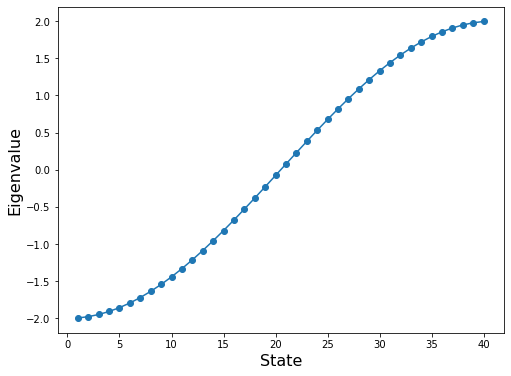

In [6]:
analytic_evals = []
wc = 0
t = 1
N = 40
for nn in range(N):
    eval = wc - 2*t*np.cos(2*np.pi*nn/N)
    analytic_evals.append(eval)
analytic_evals = np.sort(np.real(analytic_evals))

evals = np.sort(np.real(wh))
    
xs = np.linspace(1,40,40)
figure = plt.figure(figsize=(8,6))
plt.plot(xs, evals, "o-", label="Eigenvalues from Diagonalization")
#plt.plot(analytic_evals, "o", label="Analytic Eigenvalues")
plt.xlabel("State", fontsize=16)
plt.ylabel("Eigenvalue", fontsize = 16);
#plt.title("Eigenvalues (Lowest to Highest Energy)", fontsize=18)
#plt.legend(fontsize=12);

We do not see any outlier eigenvalues in this system, which is consistent with there being no "defect" (all cavities are identical).  Our analytical prediction for the eigenvalues was correct.  The eigenvalues are given by:

$E(n) = \omega_c - 2 t cos(\frac{2 \pi n}{N})$

### Case 2:  N=40, M=1, one emitter in cavity 20

In [7]:
n = 40
e_list = [0]*n
e_list[n//2-1] = 1  #add one emitter at halfway point
g_list = [3]*n

#assign variables for three return values of construct_h
h = construct_h(n, m=1, e_list=e_list, g_list=g_list)  

wh, vh = LA.eigh(h)  #diagonalize

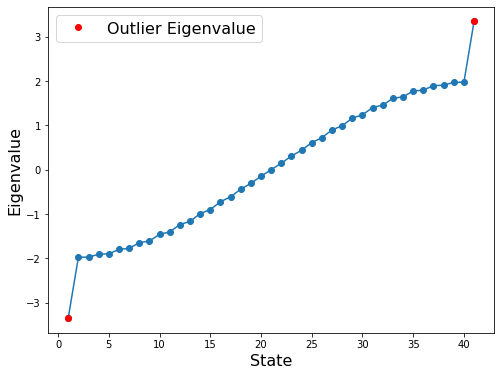

In [8]:
#number of eigenvalues = number of emitters + number of cavities
make_eigenvalue_plot(wh, n)

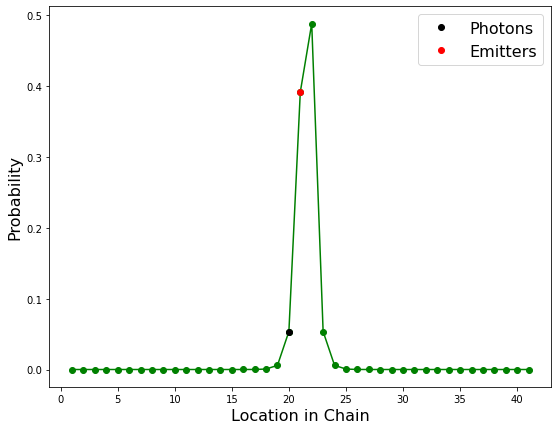

In [9]:
make_probability_plot(vh, n, 0)

### Case 3:  N=40, M=1, a block of emitters

In [10]:
n = 40
block_start = 17  #starting location of block
block_size = 5  #length of block
e_list = [0]*n
g_list = [3]*n
for i in range(block_start, block_start+block_size):  #add emitters in a block of adjacent cavities
    e_list[i] = 1

#assign variables for three return values of construct_h
h = construct_h(n, m=1, e_list=e_list, g_list=g_list)  

wh, vh = LA.eigh(h)  #diagonalize

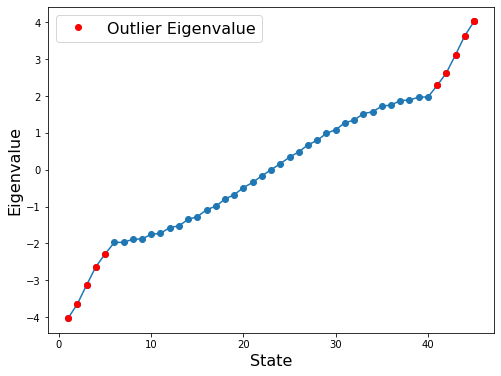

In [11]:
evals = np.sort(np.real(wh))

make_eigenvalue_plot(wh, n)
for i in range(1,5):
    plt.plot(i+1, evals[i], "o", color="red", label="Outlier Eigenvalue")
for i in range(40,45):
    plt.plot(i+1, evals[i], "o", color="red", label="Outlier Eigenvalue")

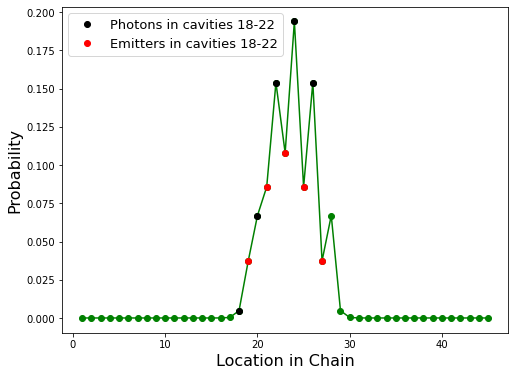

In [12]:
i = 0  #choose eigenvector to plot
evec = vh[:,i][::-1] 

xs = np.linspace(1, n+np.sum(e_list), n+np.sum(e_list))
figure = plt.figure(figsize=(8,6))
plt.plot(xs, evec**2, 'o-', color="green")

#code to generate black and red dots for block of emitters
loc = block_start
#must put one iteration outside of loop to avoid repeating labels in legend
plt.plot(loc+1, evec[loc]**2, "o", color="black", label="Photons in cavities 18-22")
plt.plot(loc+2, evec[loc+1]**2, "o", color="red", label="Emitters in cavities 18-22")
for ind in range(block_size-1):
    loc+=2
    plt.plot(loc+1, evec[loc]**2, "o", color="black")
    plt.plot(loc+2, evec[loc+1]**2, "o", color="red")

plt.xlabel("Location in Chain", fontsize=16)
plt.ylabel("Probability", fontsize=16)
#plt.title("Squared Components of Lowest-Energy Eigenvector", fontsize=18)
plt.legend(fontsize=13);

# Investigation 2: Quantum State Transfer

#### Engineering each J (reproducing results of Christandl paper)

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


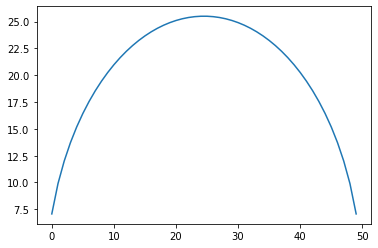

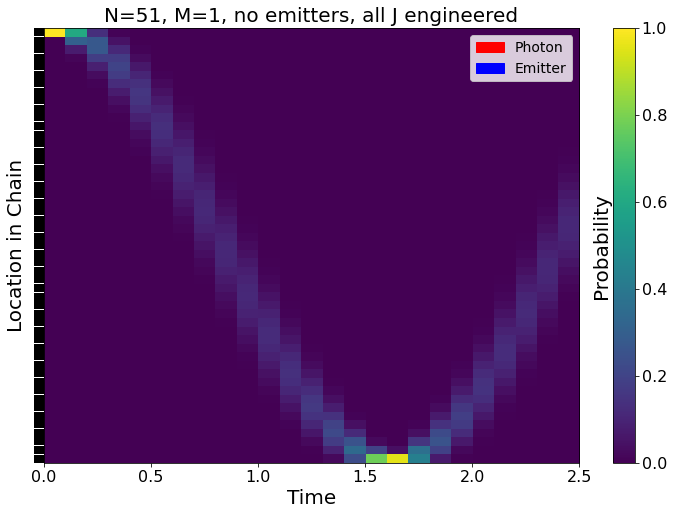

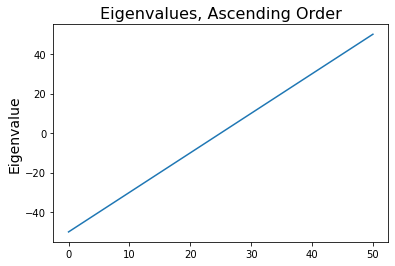

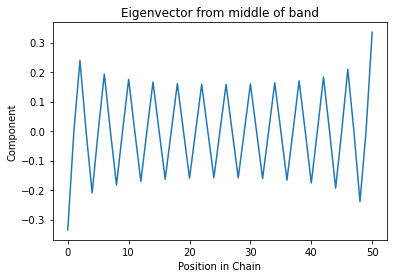

In [13]:
n=51
num_steps = 25
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = []
for i in range(1, n):
    j_list.append(np.sqrt(i*(n-i)))
plt.plot(j_list)

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list, fig_size=(12,8))
plt.title("N=51, M=1, no emitters, all J engineered", fontsize=20)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of band");

#### Changing one J value at each end (reproducing results of Zwick paper)

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


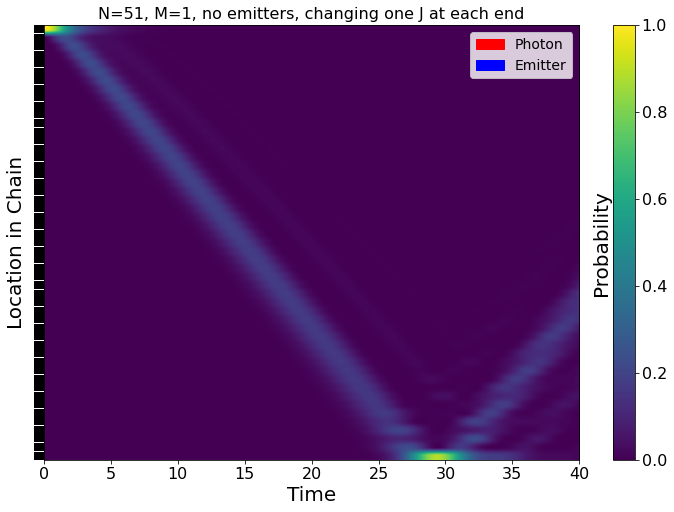

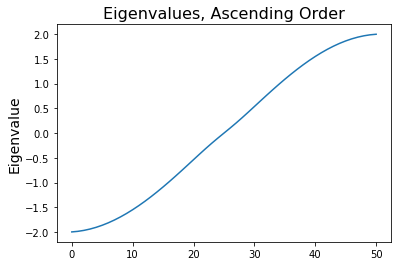

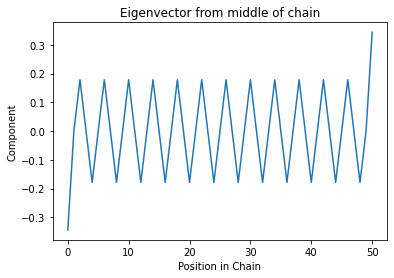

In [14]:
n=51
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = n**(-1/6)  #proportionality formula from Zwick paper
j_list[-1] = n**(-1/6)

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list)
plt.title("N=51, M=1, no emitters, changing one J at each end", fontsize=16)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of chain");

#### Changing two J values at each end (reproducing results of Apollaro paper)

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


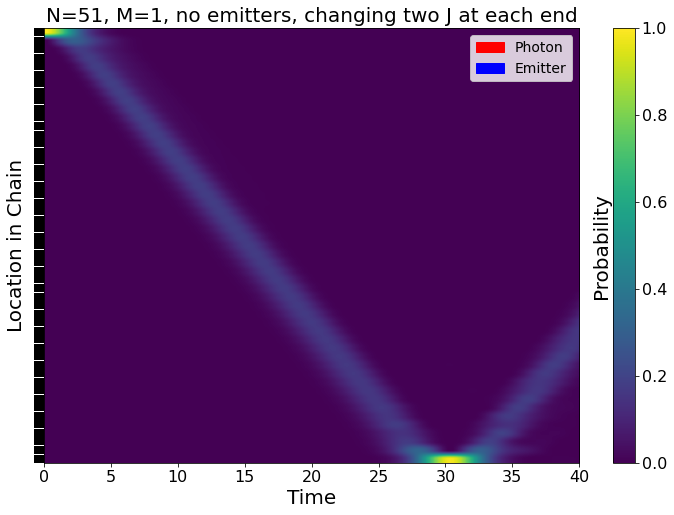

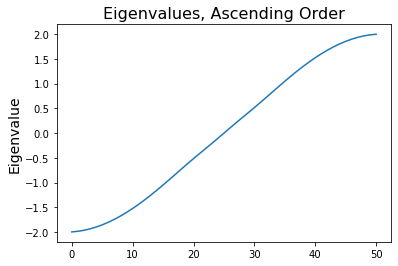

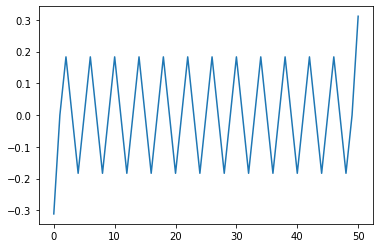

In [15]:
n=51
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = .4322  #optimal values for n=51 from Apollaro paper
j_list[-1] = .4322
j_list[1] = .7338
j_list[-2] = .7338

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list)
plt.title("N=51, M=1, no emitters, changing two J at each end", fontsize=20)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,25]);

#### Comparison of defect J at ends vs. emitters at ends

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


0.900264056559303


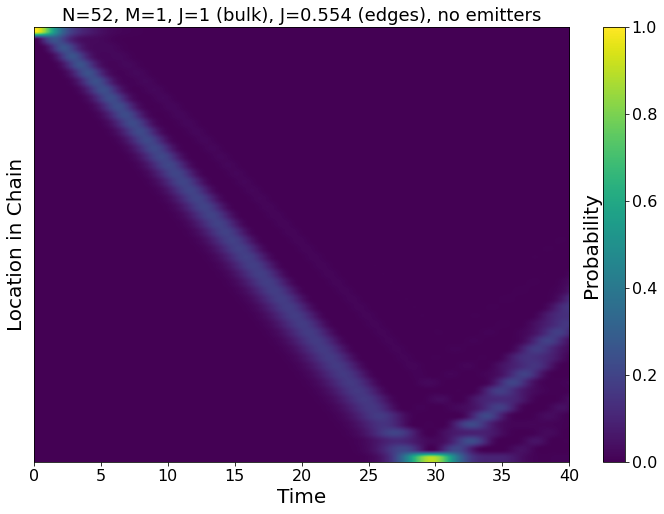

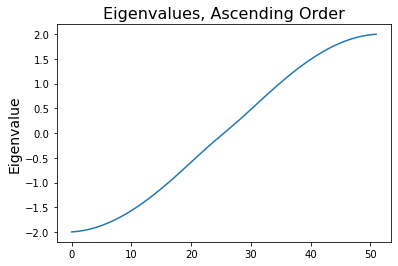

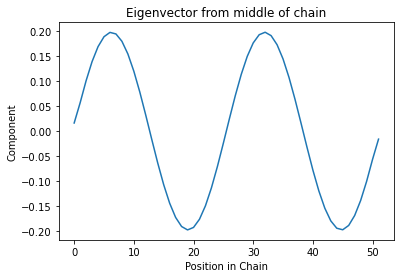

In [16]:
#defect J, no emitters

n=52
num_steps = 400
dt = 0.1
psi_0 = [0]*n
psi_0[0]=1

j_list = [1]*(n-1)
j_list[0] = 0.554  #recommended in Banchi paper for N=51
j_list[-1] = 0.554

h = construct_h(n, m=1, e_list=[0]*n, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps)
print(np.amax(prob_list[100:]))

time_evolve_colorplot(prob_list, tick_width=6, patch=False)
plt.title("N=52, M=1, J=1 (bulk), J=0.554 (edges), no emitters", fontsize=18)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16)

fig = plt.figure()
plt.plot(vh[:,3])
plt.xlabel("Position in Chain")
plt.ylabel("Component")
plt.title("Eigenvector from middle of chain");

wh_couplings = wh;
vh_couplings = vh;
h_couplings = h;

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


0.9002640565593039


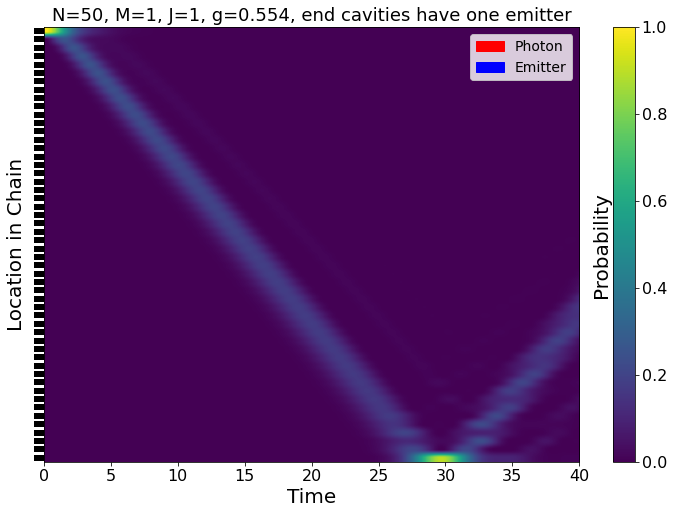

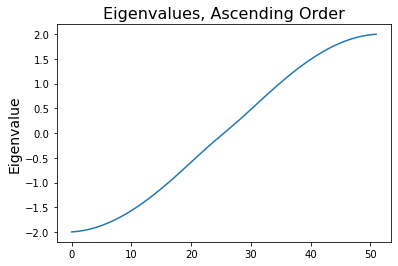

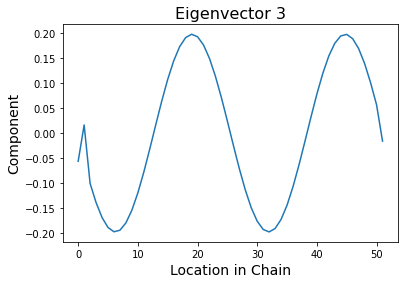

In [17]:
#Figure 10 in my report
#emitters in end cavities

n=50
m=1
num_steps = 400
dt = 0.1

e_list = [0]*n
e_list[0] = e_list[-1] = 1

j_list = [1]*(n-1)  
g_list = [0.554]*len(e_list)

psi_0 = [0]*(n + np.sum(e_list))
psi_0[1]=1
 
h = construct_h(n, m, e_list=e_list, j_list=j_list, g_list=g_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps, dt)

print(np.amax(prob_list[100:]))

prob_list[:, [1, 0]] = prob_list[:, [0, 1]]

time_evolve_colorplot(prob_list, tick_width=6, ends=True)
plt.title("N=50, M=1, J=1, g=0.554, end cavities have one emitter", fontsize=18)

fig = plt.figure()
plt.plot(wh)
plt.ylabel("Eigenvalue", fontsize=14)
plt.title("Eigenvalues, Ascending Order", fontsize=16);

ev = 3
fig = plt.figure()
plt.plot(vh[:,ev])
plt.ylabel("Component", fontsize=14)
plt.xlabel("Location in Chain", fontsize=14)
plt.title("Eigenvector {}".format(ev), fontsize=16);

wh_emitter = wh;
vh_emitter = vh;
h_emitter = h;

Above, we see that the system with N=52 and defect J at each end is equivalent to the system with N=50 and an emitter in each end cavity, under the condition that the defect J' = g.  The printed value is the maximum probability of the excitation appearing at the opposite end of the array.  This value is the same for both systems, indicating that they have identical (and good!) quantum state transfer.  This effect is true in general, for an emitter-in-end-cavities CCA of length N and a defect J array of length N+2.  Their Hamiltonians are similar matrices (they would be identical except for the opposite signs of J and g in the Tavis-Cummings-Hubbard model), and so they have identical eigenvalues and thus identical time evolution.  They are basically analogous systems.  

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


0.415915862104341


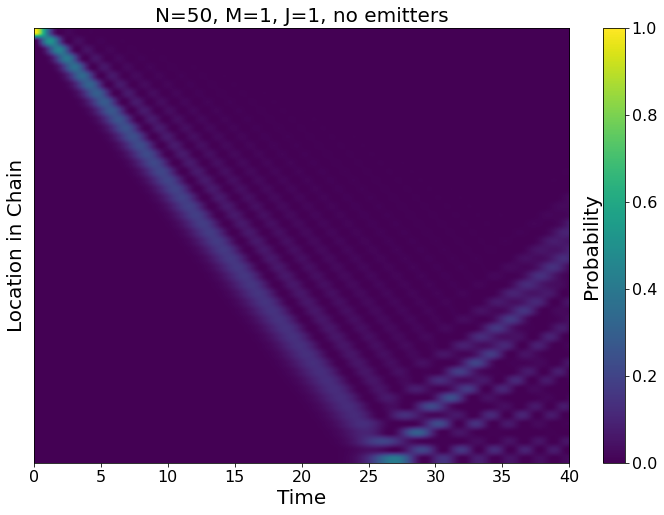

In [18]:
#Figure 9 in my report
#no emitters, uniform J

n=50
m=1
num_steps = 400
dt = 0.1

e_list = [0]*n
j_list = [1]*(n-1)    

psi_0 = [0]*(n + np.sum(e_list))
psi_0[0]=1
 
h = construct_h(n, m, e_list=e_list, j_list=j_list)
t_list, prob_list = time_evolve(h, psi_0, num_steps, dt)
print(np.max(prob_list[100:]))

time_evolve_colorplot(prob_list, patch=False, tick_width=6)
plt.title("N=50, M=1, J=1, no emitters", fontsize=20);

In the above section, we put an emitter in every cavity for an array with uniform J.  The state transfer appears to be poor regardless of the value of g.  The behavior is similar to what we would expect if the emitters were not present (dispersion).

## Time Evolution: Basic Checks (Rabi Oscillation)

Below, we verify that the code is working correctly by creating a Rabi oscillation, since this is a simple situation with a known result.

#### N=2, M=1, no emitters

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


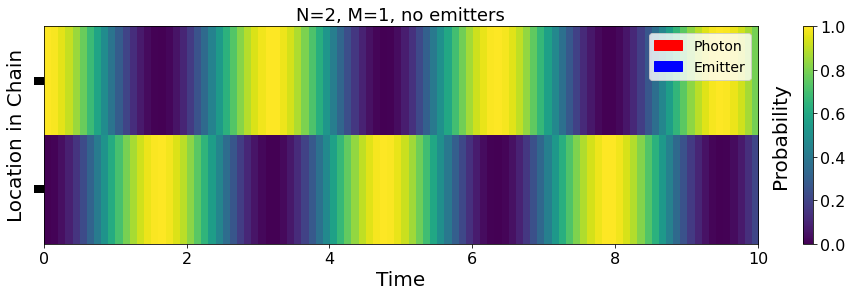

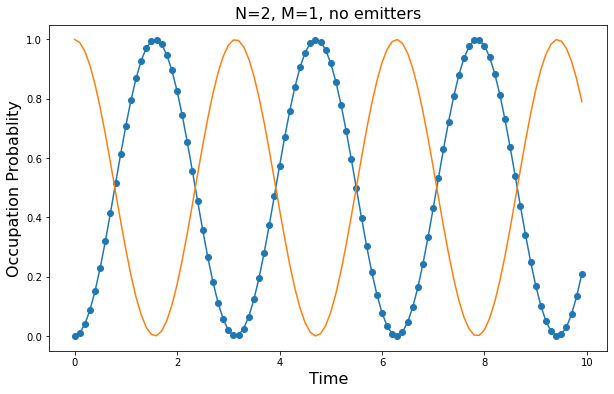

In [19]:
num_steps=100
dt = 0.1

h = construct_h(n=2, m=1, e_list=[0]*2)
psi_0 = [1,0]  #photon starts in left cavity
t_list, prob_list = time_evolve(h, psi_0, num_steps)

time_evolve_colorplot(prob_list, fig_size=(16,4))
plt.title("N=2, M=1, no emitters", fontsize=18)

time_evolve_lineplot(t_list, prob_list, Rabi=True)
plt.title("N=2, M=1, no emitters", fontsize=16);

- Period = 2pi/omega = pi, where omega = highest eval - lowest eval = 2.  
- Note that the Rabi oscillation cos^2(omega * t/2) has the same period as cos(omega * t) by the trigonometric identity cos^2(x) = (1+cos(2x))/2.  This is why the period is given by 2pi/omega.  The only difference is that the Rabi oscillation has all positive values.  

The probability as a function of time for the left cavity occupation matches up with a Rabi oscillation, which is what we would expect for a two-level atom.  So, the code is working correctly.  We can see that the probabilities oscillate between zero and one, with the sum of the two probabilities always adding to one.  This is another indication that the results are correct.

#### N=2, M=1, one emitter in left cavity

<ipython-input-3-edf158aa32f4>:7: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  u_diag = np.zeros([len(wh), len(wh)], dtype=np.complex)


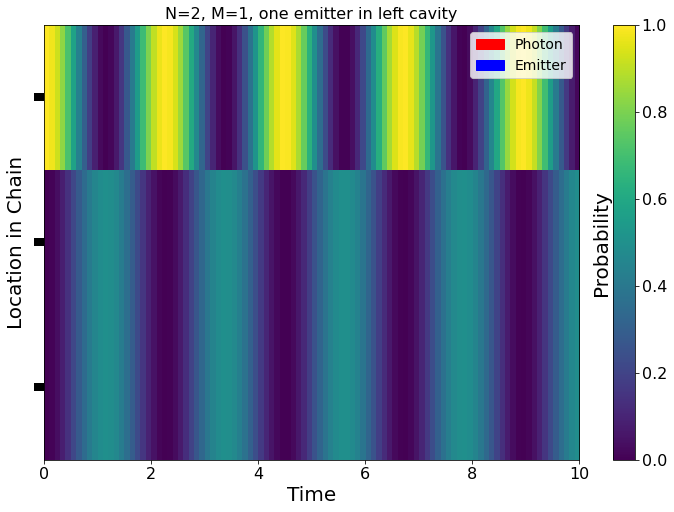

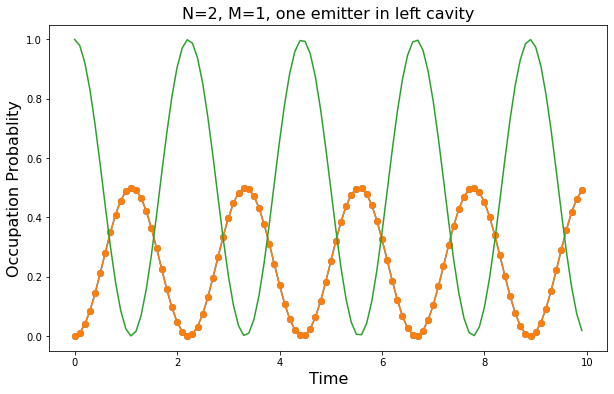

In [20]:
h = construct_h(n=2, m=1, e_list = [1,0])
psi_0 = [1,0,0]  #photon starts in left cavity
t_list, prob_list = time_evolve(h, psi_0, num_steps = 100)

time_evolve_colorplot(prob_list)
plt.title("N=2, M=1, one emitter in left cavity", fontsize=16)

time_evolve_lineplot(t_list, prob_list, Rabi=True)
plt.title("N=2, M=1, one emitter in left cavity", fontsize=16);

- Period: 2pi / omega = 2.22, where omega = highest eval - lowest eval = 2.83

The left cavity photon probability matches up with the Rabi oscillation, as we would expect (overlapping blue and red lines).  The left cavity emitter and right cavity photon states have identical probability functions (overlapping orange and green lines).  The excitation is most likely to exist as a photon in the left cavity.

Note that the frequency has changed due to the change in the eigenvalues.